# ImgProcess

Originally this process was just going to extract the GPS coordinates from the EXIF data on the photos... buuuutttttt my phones GPS was nearly accurate enough for this project so I had to go back and retake the photos and align a photo times to the points on my garmin.

In [1]:
from datetime import datetime, timedelta
from dateutil import tz

import re
import pickle

import geopandas as gpd
import pandas as pd

import shapely

import geoplot as gplt

import gpxpy

from matplotlib import pyplot as plt

In [2]:
files = !ls img_walnutst/*.jpg
files

['img_walnutst/IMG_20230920_115453460_HDR.jpg',
 'img_walnutst/IMG_20230920_115540327_HDR.jpg',
 'img_walnutst/IMG_20230920_115625903_HDR.jpg',
 'img_walnutst/IMG_20230920_115804977_HDR.jpg',
 'img_walnutst/IMG_20230920_115835241_HDR.jpg',
 'img_walnutst/IMG_20230920_115902336.jpg',
 'img_walnutst/IMG_20230920_115949304_HDR.jpg',
 'img_walnutst/IMG_20230920_120019176_HDR.jpg',
 'img_walnutst/IMG_20230920_120102166_HDR.jpg',
 'img_walnutst/IMG_20230920_120359141_HDR.jpg',
 'img_walnutst/IMG_20230920_120423507.jpg',
 'img_walnutst/IMG_20230920_120519692_HDR.jpg',
 'img_walnutst/IMG_20230920_120648845_HDR.jpg',
 'img_walnutst/IMG_20230920_120836344.jpg',
 'img_walnutst/IMG_20230920_120906739_HDR.jpg',
 'img_walnutst/IMG_20230920_120953573_HDR.jpg',
 'img_walnutst/IMG_20230920_121211362_HDR.jpg',
 'img_walnutst/IMG_20230920_121235601_HDR.jpg',
 'img_walnutst/IMG_20230920_123533613.jpg']

In [3]:
s3Loc = "https://s3.amazonaws.com/filestogeaux.garyscorner.net/pub/"

In [4]:
def convertGPS(cord):
    outCord = cord[0]
    
    outCord += cord[1] / 60.0
    
    outCord += cord[2] / 3600.0
    
    return outCord

In [5]:
def getMetaData(files, reg = re.compile('^img_walnutst/IMG_([^_]+_[^_]{9})'), s3Loc = s3Loc):

    outList = []
    
    for file in files:
        try:
            timeStr = reg.match(file).groups()[0] + '000'
        except Exception as e:
            print(file)
            raise(e)

        date = datetime.strptime(timeStr, '%Y%m%d_%H%M%S%f')
        outList.append({
                  'url':s3Loc+file,
                  'file':file,
                  'date':date,

                 })


    return pd.DataFrame.from_dict( outList )


In [6]:
metaDataDf = getMetaData(files) 
metaDataDf.head()

,url,file,date
0,https://s3.amazonaws.com/filestogeaux.garyscor...,img_walnutst/IMG_20230920_115453460_HDR.jpg,2023-09-20 11:54:53.460
1,https://s3.amazonaws.com/filestogeaux.garyscor...,img_walnutst/IMG_20230920_115540327_HDR.jpg,2023-09-20 11:55:40.327
2,https://s3.amazonaws.com/filestogeaux.garyscor...,img_walnutst/IMG_20230920_115625903_HDR.jpg,2023-09-20 11:56:25.903
3,https://s3.amazonaws.com/filestogeaux.garyscor...,img_walnutst/IMG_20230920_115804977_HDR.jpg,2023-09-20 11:58:04.977
4,https://s3.amazonaws.com/filestogeaux.garyscor...,img_walnutst/IMG_20230920_115835241_HDR.jpg,2023-09-20 11:58:35.241


In [7]:
with open("datasets/activity_12068352003_PhotoWalk.gpx") as f:
    photoWalk = gpxpy.parse(f)

In [8]:
timeZone = tz.tzoffset('CDT',-5)

In [9]:
photoWalkPts = [shapely.geometry.Point((pt.longitude, pt.latitude)) for pt in photoWalk.tracks[0].segments[0].points]
photoWalkTimes = [pt.time for pt in photoWalk.tracks[0].segments[0].points]



photoWalkDf = gpd.GeoSeries(photoWalkPts, crs='WGS84', index=photoWalkTimes)                                           

photoWalkDf.index = photoWalkDf.index - timedelta(hours=5)  #localtime
photoWalkDf.index = photoWalkDf.index.tz_localize(None)

photoWalkDf.head()

2023-09-20 11:46:01    POINT (-90.12796 29.92606)
2023-09-20 11:46:02    POINT (-90.12794 29.92606)
2023-09-20 11:46:03    POINT (-90.12793 29.92608)
2023-09-20 11:46:04    POINT (-90.12792 29.92609)
2023-09-20 11:46:05    POINT (-90.12790 29.92609)
dtype: geometry

In [10]:
photoWalkDf.index.get_loc

<bound method DatetimeIndex.get_loc of DatetimeIndex(['2023-09-20 11:46:01', '2023-09-20 11:46:02',
               '2023-09-20 11:46:03', '2023-09-20 11:46:04',
               '2023-09-20 11:46:05', '2023-09-20 11:46:06',
               '2023-09-20 11:46:07', '2023-09-20 11:46:08',
               '2023-09-20 11:46:09', '2023-09-20 11:46:10',
               ...
               '2023-09-20 12:45:34', '2023-09-20 12:45:35',
               '2023-09-20 12:45:36', '2023-09-20 12:45:37',
               '2023-09-20 12:45:38', '2023-09-20 12:45:39',
               '2023-09-20 12:45:40', '2023-09-20 12:45:41',
               '2023-09-20 12:45:42', '2023-09-20 12:45:43'],
              dtype='datetime64[ns]', length=3580, freq=None)>

In [11]:
f"Total time:  {photoWalkDf.index.max()-photoWalkDf.index.min()}"

'Total time:  0 days 00:59:42'

In [12]:
metaDataDf = gpd.GeoDataFrame(metaDataDf,\
                              geometry=metaDataDf['date'].map(\
                                        lambda d: photoWalkDf.asof(d)   \
                                                             ),\
                              crs='WGS84')

In [13]:
metaDataDf.head()

,url,file,date,geometry
0,https://s3.amazonaws.com/filestogeaux.garyscor...,img_walnutst/IMG_20230920_115453460_HDR.jpg,2023-09-20 11:54:53.460,POINT (-90.13195 29.92711)
1,https://s3.amazonaws.com/filestogeaux.garyscor...,img_walnutst/IMG_20230920_115540327_HDR.jpg,2023-09-20 11:55:40.327,POINT (-90.13193 29.92719)
2,https://s3.amazonaws.com/filestogeaux.garyscor...,img_walnutst/IMG_20230920_115625903_HDR.jpg,2023-09-20 11:56:25.903,POINT (-90.13158 29.92748)
3,https://s3.amazonaws.com/filestogeaux.garyscor...,img_walnutst/IMG_20230920_115804977_HDR.jpg,2023-09-20 11:58:04.977,POINT (-90.13124 29.92806)
4,https://s3.amazonaws.com/filestogeaux.garyscor...,img_walnutst/IMG_20230920_115835241_HDR.jpg,2023-09-20 11:58:35.241,POINT (-90.13113 29.92819)


<GeoAxesSubplot:>

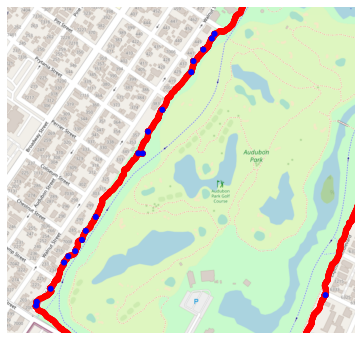

In [14]:
ax=gplt.webmap(metaDataDf,projection=gplt.crs.WebMercator())
gplt.pointplot(photoWalkDf, color='r',  ax=ax, zorder=500)
gplt.pointplot(metaDataDf, color='b',  ax=ax, zorder=501)

In [15]:
metaDataDf.to_pickle('img_walnutstMetaData.pickle')

In [16]:
str(datetime.now())

'2023-09-21 12:33:30.660922'

In [17]:
!aws s3 sync --delete ./img_walnutst s3://filestogeaux.garyscorner.net/pub/img_walnutst/ --acl public-read

In [18]:
str(datetime.now())

'2023-09-21 12:33:31.940963'

In [19]:
'done!'

'done!'